# Notebook 3: Modeling 

_For USD-599 Capstone Project by Hunter Blum, Kyle Esteban Dalope, and Nicholas Lee (Summer 2023)_

***

**Content Overview:**
1. Pipeline Creation
2. Data Splitting - Split by property_type_binary and train test split for each
3. Modeling - Two sets of models based on propery_type_binary that will be evaluated separately
4. Results

In [1]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Lasso, Ridge, ElasticNet

#import warnings
#warnings.filterwarnings("ignore")

In [2]:
# Read in data from the previous notebook
clean_data = pd.read_csv("../Data/model_ready.csv.gz", compression = "gzip")

In [3]:
clean_data.dtypes

host_listings_count                             float64
property_type                                    object
room_type                                        object
bathrooms                                       float64
bedrooms                                        float64
price                                           float64
minimum_nights                                    int64
maximum_nights                                    int64
minimum_minimum_nights                          float64
maximum_maximum_nights                          float64
has_availability                                 object
availability_30                                   int64
availability_365                                  int64
instant_bookable                                 object
calculated_host_listings_count                    int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               

In [4]:
# Change some features to the proper data types
# i.e. zipcode to categorical
clean_data["zipcode"] = clean_data["zipcode"].astype("category")

**Do we need to drop _property_type_ and _room_type_?**

In [5]:
# Split the data by property type
house_df = clean_data.loc[clean_data["property_type_binary"] == "house"]
room_df = clean_data.loc[clean_data["property_type_binary"] == "room"]

# Drop the property types
house_df = house_df.drop(columns=['property_type_binary'])
room_df = room_df.drop(columns=['property_type_binary'])

## Pipeline Setup
-  Establish a unique pipeline for numerical and categorical columns separately
- Partition the dataset into training and test set (75:25 split)
- Fit and apply the transformer to the training set
- Applied the trained transformer to the test set
- Return the preprocessed, model-ready training and test sets

**Maybe we go back and keep _review_scores_average_ and in the pipeline, multiple the two features (avg. score and # of monthly reviews) together, to create a weighted score, and then drop it?**

I'm thinking if this app is for users, they will have this information will be readily accessible and they can enter it themselves. If we take this approach, we'll need to keep the original features so the vector exists for them in the model training data

In [6]:
# Separate numerical and categorical features
num_cols = house_df.select_dtypes(["int64", "float64"]).columns.tolist()
categorical_cols = house_df.select_dtypes("object").columns.tolist()

# Separate out the target
num_cols.remove('price')

**Should we add an imputer to the numerical data in the event that a user decides to leave a field empty, downstream?**

In [7]:
# Set up separate pipelines for different datatypes

# Set transformer output as a pandas dataframe
set_config(transform_output="pandas")

# Numerical Pipeline
num_pipeline = Pipeline([
    ("standardscaler", StandardScaler())
])

# Categorical Pipeline
categorical_pipeline = Pipeline([
    # Handle_unknown = "ignore" to deal with one off values in categorical features
    ("encoder", OneHotEncoder(
        sparse_output = False, drop = "if_binary", handle_unknown = "ignore"
        )
    )
])

# Global Data Pipeline
data_transformer = ColumnTransformer(
    transformers = [
        ("numerical", num_pipeline, num_cols),
        ("categorical", categorical_pipeline, categorical_cols)
    ]
)

In [8]:
# A function to output preprocessed, model-ready data using the data_transformer
def preprocess_data(data_set, pipeline = data_transformer,
                    num_cols = num_cols, categorical_cols = categorical_cols):
    
    # Data partitioning 75:25 Train-Test Split
    training_data, testing_data = train_test_split(
        data_set, test_size = 0.25, random_state = 2023
        )
    
    # Separate target from df
    training_data_X = training_data.drop(columns = ['price'])
    train_data_y = training_data['price']

    testing_data_X = testing_data.drop(columns = ['price'])
    test_data_y = testing_data['price']

    # Fit and transform the training data partition
    train_data_X = pipeline.fit_transform(training_data_X)        

    # Transform the test data set based on the training data
    test_data_X = pipeline.transform(testing_data_X)

    # Remove whitespace in col names
    train_data_X.columns = train_data_X.columns.str.replace(' ', '_')
    test_data_X.columns = test_data_X.columns.str.replace(' ', '_')

    # Remove slashes in col names
    train_data_X.columns = train_data_X.columns.str.replace('/', '_')
    test_data_X.columns = test_data_X.columns.str.replace('/', '_')

    return train_data_X, train_data_y, test_data_X, test_data_y

In [9]:
# Preprocess the house-type and room-type data sets
house_train_X, house_train_y, house_test_X, house_test_y = preprocess_data(house_df)
room_train_X, room_train_y, room_test_X, room_test_y = preprocess_data(room_df)

c:\Users\Nick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Nick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Baseline Model - Multiple Linear Regression

Since we do not have too many training features, it will be better to use backwards stepwise regression to test all of our features. 

### Room Model

We'll use statsmodels here instead of sklearn, since the diagnostic tools are a bit better.

In [117]:
# Combine the dataframe back into one for the model
room_train = pd.concat([room_train_X, room_train_y], axis = 1)

# Get string of columns for formula
cols = list(room_train_X.columns)
cols_str = " + ".join(cols)
cols_str = str(cols_str)

# Fit the model
room_reg = smf.ols(formula= 'price ~' + cols_str, 
                            data = room_train).fit()

# Model summary
print(room_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     14.76
Date:                Thu, 27 Jul 2023   Prob (F-statistic):          8.50e-131
Time:                        12:17:32   Log-Likelihood:                -17640.
No. Observations:                2491   AIC:                         3.541e+04
Df Residuals:                    2425   BIC:                         3.580e+04
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

### Residuals vs. Fitted Plot
Diagnostic plot code inspired from Jason Sadowski's R to Python Article : https://towardsdatascience.com/going-from-r-to-python-linear-regression-diagnostic-plots-144d1c4aa5a
He does have a module in GitHub, but I couldn't get it to work: https://github.com/j-sadowski/FromRtoPython



In [118]:
def resid_v_fitted_plot(fitted_reg):
    # Metrics we need
    residuals = fitted_reg.resid
    fitted = fitted_reg.fittedvalues
    smooth = lowess(residuals, fitted)
    top5 = abs(residuals).sort_values(ascending = False)[:5]

    # Plot
    fig, ax = plt.subplots()
    ax.scatter(fitted, residuals, edgecolors= 'b', facecolors = 'none')
    ax.plot(smooth[:,0], smooth[:,1], color = 'r')
    ax.set_ylabel('Residuals')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Residuals vs. Fitted')
    ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

    for i in top5.index:
        ax.annotate(i,xy=(fitted[i],residuals[i]))

    plt.show()

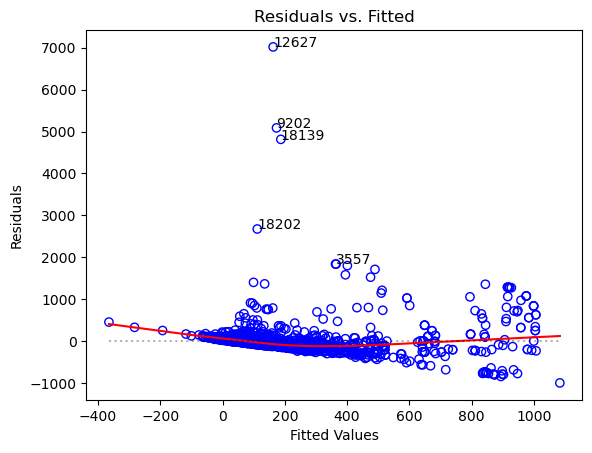

In [119]:
resid_v_fitted_plot(fitted_reg= room_reg)

### Q-Q Plot

In [120]:
def qq_plot(fitted_reg):
    # get the sorted residuals
    sorted_resid = pd.Series(fitted_reg.get_influence().resid_studentized_internal)
    sorted_resid.index = fitted_reg.resid.index
    sorted_resid = sorted_resid.sort_values(ascending=True)

    # make df from sorted resids
    df = pd.DataFrame(sorted_resid)
    df.columns = ['sorted_resid']
    df['theoretical_quants'] = stats.probplot(df['sorted_resid'], dist='norm', fit = False)[0]
    df = df.dropna()

    # Get the top five points
    ranks = abs(df['sorted_resid']).sort_values(ascending=False)
    top5 = ranks[:5]

    # Plot
    fig, ax = plt.subplots()
    x = df['theoretical_quants']
    y = df['sorted_resid']
    ax.scatter(x,y, edgecolor='b', facecolor = 'none')
    ax.set_title('Normal Q-Q')
    ax.set_ylabel('Standardized Residuals')
    ax.set_xlabel('Theoretical Quantiles')
    ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
    ax.set_xlim([x.min() -1 , x.max() + 1])
    for val in top5.index:
        ax.annotate(val,xy=(df['theoretical_quants'].loc[val],df['sorted_resid'].loc[val]))
    plt.show()

C:\Users\HunterBlum\AppData\Roaming\Python\Python39\site-packages\statsmodels\stats\outliers_influence.py:848: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
C:\Users\HunterBlum\AppData\Roaming\Python\Python39\site-packages\statsmodels\stats\outliers_influence.py:848: RuntimeWarning: invalid value encountered in divide
  return self.resid / sigma / np.sqrt(1 - hii)


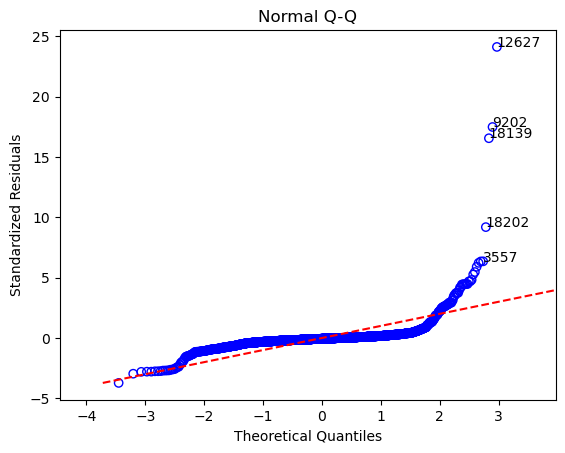

In [121]:
qq_plot(fitted_reg = room_reg)

### Scale-Location Plot

In [122]:
def scale_location_plot(fitted_reg):
    # Get sqrt of resids
    resids = fitted_reg.get_influence().resid_studentized_internal
    sqrt_resids = pd.Series(np.sqrt(np.abs(resids)))
    sqrt_resids.index = fitted_reg.resid.index
    smooth = lowess(sqrt_resids, fitted_reg.fittedvalues)
    
    top5 = abs(sqrt_resids).sort_values(ascending=False)[:5]

    # Plot
    fig, ax = plt.subplots()
    ax.scatter(fitted_reg.fittedvalues, sqrt_resids, edgecolors = 'b', facecolors = 'none')
    ax.plot(smooth[:,0],smooth[:,1],color = 'r')
    ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Scale-Location')
    ax.set_ylim(0,max(sqrt_resids)+0.1)
    for i in top5.index:
        ax.annotate(i,xy=(fitted_reg.fittedvalues[i],sqrt_resids[i]))
    plt.show()


C:\Users\HunterBlum\AppData\Roaming\Python\Python39\site-packages\statsmodels\stats\outliers_influence.py:848: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
C:\Users\HunterBlum\AppData\Roaming\Python\Python39\site-packages\statsmodels\stats\outliers_influence.py:848: RuntimeWarning: invalid value encountered in divide
  return self.resid / sigma / np.sqrt(1 - hii)


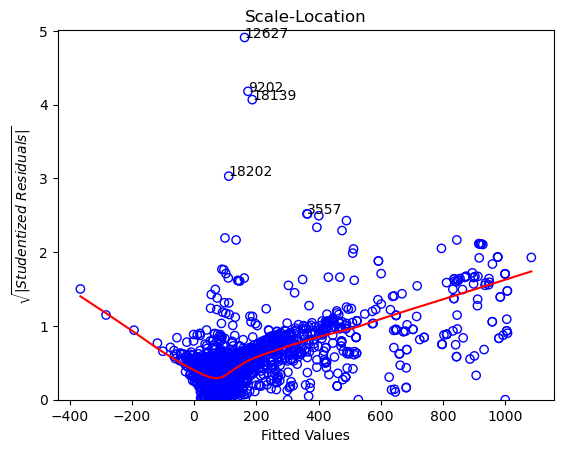

In [123]:
scale_location_plot(fitted_reg=room_reg)

### Cook's Distance

In [124]:
def cook_d_plot(fitted_reg):
    resids = pd.Series(fitted_reg.get_influence().resid_studentized_internal)
    resids.index = fitted_reg.resid.index
    df = pd.DataFrame(resids)
    df.columns = ['resids']
    df['leverage'] = fitted_reg.get_influence().hat_matrix_diag
    df = df.dropna()
    smoothed = lowess(df['resids'],df['leverage'])
    sorted_resids = abs(df['resids']).sort_values(ascending = False)
    top5 = sorted_resids[:5]

    fig, ax = plt.subplots()
    x = df['leverage']
    y = df['resids']
    xpos = max(x)+max(x)*0.01  
    ax.scatter(x, y, edgecolors = 'b', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('Studentized Residuals')
    ax.set_xlabel('Leverage')
    ax.set_title('Residuals vs. Leverage')
    ax.set_ylim(min(y)-min(y)*0.15,30)
    ax.set_xlim(-0.01,max(x)+max(x)*0.05)
    plt.tight_layout()
    for val in top5.index:
        ax.annotate(val,xy=(x.loc[val],y.loc[val]))

    cooksx = np.linspace(min(x), xpos, 50)
    p = len(fitted_reg.params)
    poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
    poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
    negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
    negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

    ax.plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
    ax.plot(cooksx,poscooks05y, ls = ':', color = 'r')
    ax.plot(cooksx,negcooks1y, ls = ':', color = 'r')
    ax.plot(cooksx,negcooks05y, ls = ':', color = 'r')
    ax.plot([0,0],ax.get_ylim(), ls=":", alpha = .3, color = 'k')
    ax.plot(ax.get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
    ax.annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
    ax.annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
    ax.annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
    ax.annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
    ax.legend()
    plt.show()

C:\Users\HunterBlum\AppData\Local\Temp\ipykernel_18428\3334856127.py:29: RuntimeWarning: invalid value encountered in sqrt
  poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
C:\Users\HunterBlum\AppData\Local\Temp\ipykernel_18428\3334856127.py:30: RuntimeWarning: invalid value encountered in sqrt
  poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
C:\Users\HunterBlum\AppData\Local\Temp\ipykernel_18428\3334856127.py:31: RuntimeWarning: invalid value encountered in sqrt
  negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
C:\Users\HunterBlum\AppData\Local\Temp\ipykernel_18428\3334856127.py:32: RuntimeWarning: invalid value encountered in sqrt
  negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)


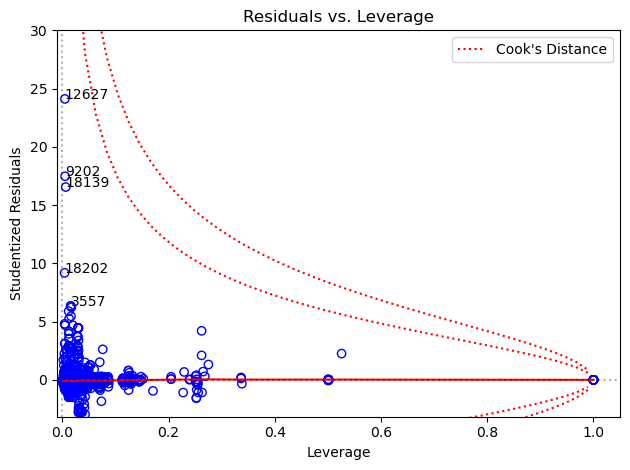

In [125]:
cook_d_plot(fitted_reg=room_reg)

In [168]:
# Save our preds
room_reg_pred = room_reg.predict(room_test_X)

### Entire Home Model

In [126]:
# Combine the dataframe back into one for the model
house_train = pd.concat([house_train_X, house_train_y], axis = 1)

# Get string of columns for formula
cols = list(house_train_X.columns)
cols_str = " + ".join(cols)
cols_str = str(cols_str)

# Fit the model
house_reg = smf.ols(formula= 'price ~' + cols_str, 
                            data = house_train).fit()

# Model summary
print(house_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     199.4
Date:                Thu, 27 Jul 2023   Prob (F-statistic):               0.00
Time:                        12:17:35   Log-Likelihood:                -80017.
No. Observations:               11379   AIC:                         1.601e+05
Df Residuals:                   11331   BIC:                         1.605e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

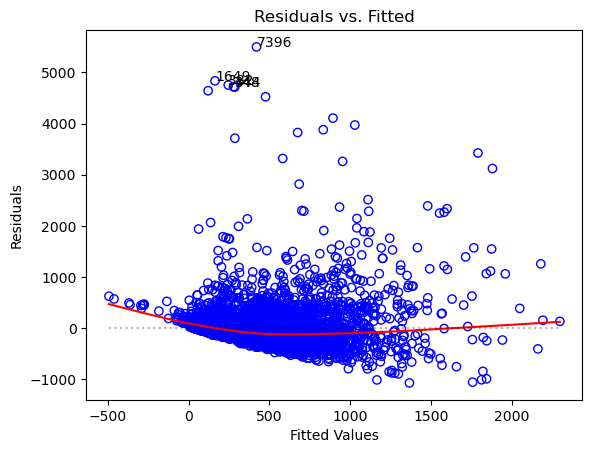

In [127]:
resid_v_fitted_plot(fitted_reg= house_reg)

C:\Users\HunterBlum\AppData\Roaming\Python\Python39\site-packages\statsmodels\stats\outliers_influence.py:848: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


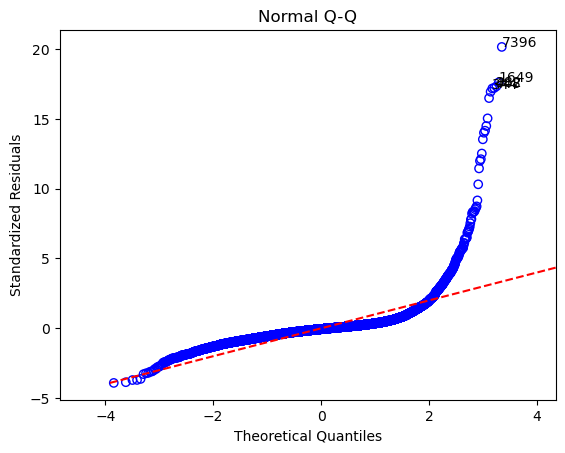

In [128]:
qq_plot(fitted_reg = house_reg)

C:\Users\HunterBlum\AppData\Roaming\Python\Python39\site-packages\statsmodels\stats\outliers_influence.py:848: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


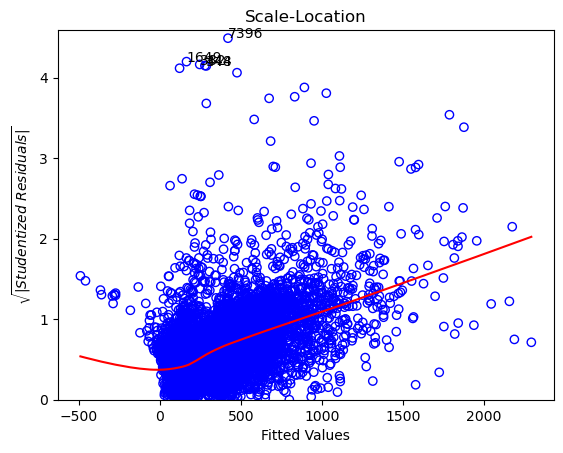

In [129]:
scale_location_plot(fitted_reg = house_reg)

C:\Users\HunterBlum\AppData\Local\Temp\ipykernel_18428\3334856127.py:29: RuntimeWarning: invalid value encountered in sqrt
  poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
C:\Users\HunterBlum\AppData\Local\Temp\ipykernel_18428\3334856127.py:30: RuntimeWarning: invalid value encountered in sqrt
  poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
C:\Users\HunterBlum\AppData\Local\Temp\ipykernel_18428\3334856127.py:31: RuntimeWarning: invalid value encountered in sqrt
  negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
C:\Users\HunterBlum\AppData\Local\Temp\ipykernel_18428\3334856127.py:32: RuntimeWarning: invalid value encountered in sqrt
  negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)


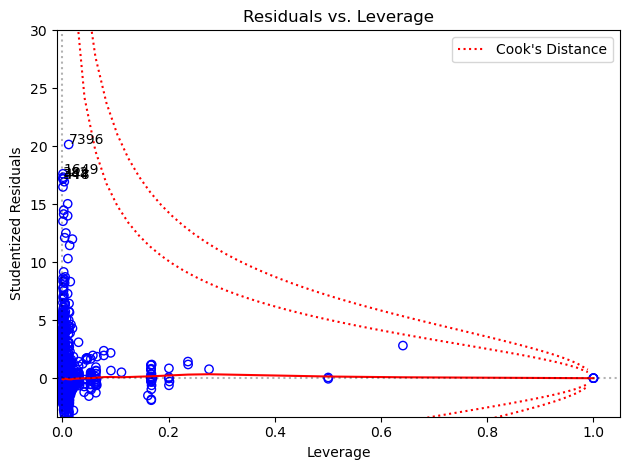

In [130]:
cook_d_plot(fitted_reg = house_reg)

In [132]:
# Save our preds
house_reg_pred = house_reg.predict(house_test_X)

## Lasso Regression
### Room Model

In [137]:
# Set up hyperparameter options
alpha = [0.001, 0.01, 0.1, 0.2, 0.5, 1, 5, 10, 20, 25, 50, 100]

# Setup model pipeline so we can reference it in param_distributions
lasso_pipe = Pipeline(steps = [('lasso', Lasso())])

# Search
lasso_room_tuned = GridSearchCV(
    estimator= lasso_pipe,
    param_grid = {'lasso__alpha' : alpha},
    scoring= 'neg_root_mean_squared_error', 
    n_jobs=-1
).fit(room_train_X, room_train_y)

# Return the best model parameters
lasso_room_tuned.best_params_

{'lasso__alpha': 0.5}

In [138]:
lasso_room_pred = lasso_room_tuned.predict(room_test_X)

### House Model

In [143]:
# Search
lasso_house_tuned = GridSearchCV(
    estimator= lasso_pipe,
    param_grid = {'lasso__alpha' : alpha},
    scoring= 'neg_root_mean_squared_error', 
    n_jobs=-1
).fit(house_train_X, house_train_y)

# Return the best model parameters
lasso_house_tuned.best_params_

{'lasso__alpha': 0.1}

In [140]:
lasso_house_pred = lasso_house_tuned.predict(house_test_X)

## Ridge Regression
### Room Model

In [144]:
# Set up hyperparameter options
alpha = [0.001, 0.01, 0.1, 0.2, 0.5, 1, 5, 10, 20, 25, 50, 100]

# Setup model pipeline so we can reference it in param_distributions
ridge_pipe = Pipeline(steps = [('ridge', Ridge())])

# Search
ridge_room_tuned = GridSearchCV(
    estimator= ridge_pipe,
    param_grid = {'ridge__alpha' : alpha},
    scoring= 'neg_root_mean_squared_error', 
    n_jobs=-1
).fit(room_train_X, room_train_y)

# Return the best model parameters
ridge_room_tuned.best_params_

{'ridge__alpha': 5}

In [146]:
ridge_room_pred = ridge_room_tuned.predict(room_test_X)

### House Model

In [147]:
# Search
ridge_house_tuned = GridSearchCV(
    estimator= ridge_pipe,
    param_grid = {'ridge__alpha' : alpha},
    scoring= 'neg_root_mean_squared_error', 
    n_jobs=-1
).fit(house_train_X, house_train_y)

# Return the best model parameters
ridge_house_tuned.best_params_

{'ridge__alpha': 5}

In [149]:
ridge_house_pred = ridge_house_tuned.predict(house_test_X)

## Elastic Net Model
### Room Model

In [154]:
# Set up hyperparameter options
alpha = [0.001, 0.01, 0.1, 0.2, 0.5, 1, 5, 10, 20, 25, 50, 100]
l1_ratio = np.arange(0, 1, 0.1)

# Setup model pipeline so we can reference it in param_distributions
enet_pipe = Pipeline(steps = [('enet', ElasticNet())])

# Search
enet_room_tuned = GridSearchCV(
    estimator= enet_pipe,
    param_grid = {'enet__alpha' : alpha,
                  'enet__l1_ratio' : l1_ratio},
    scoring= 'neg_root_mean_squared_error', 
    n_jobs=-1
).fit(room_train_X, room_train_y)

# Return the best model parameters
enet_room_tuned.best_params_

{'enet__alpha': 0.01, 'enet__l1_ratio': 0.9}

In [155]:
enet_room_pred = enet_room_tuned.predict(room_test_X)

### House Model

In [156]:
# Search
enet_house_tuned = GridSearchCV(
    estimator= enet_pipe,
    param_grid = {'enet__alpha' : alpha,
                  'enet__l1_ratio' : l1_ratio},
    scoring= 'neg_root_mean_squared_error', 
    n_jobs=-1
).fit(house_train_X, house_train_y)

# Return the best model parameters
enet_house_tuned.best_params_

{'enet__alpha': 0.001, 'enet__l1_ratio': 0.2}

In [157]:
enet_house_pred = enet_house_tuned.predict(house_test_X)

## Random Forest

In [12]:
# Combine the dataframe back into one for the model
room_train = pd.concat([room_train_X, room_train_y], axis = 1)

# Import Random Forest Regressor Model
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [200, 500, 1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2, 5, 10]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Dictionary for GridSearch
param_grid_rf = {"n_estimators": n_estimators,
               "max_features": max_features,
               "max_depth": max_depth,
               "min_samples_split": min_samples_split,
               "min_samples_leaf": min_samples_leaf}

# Create a Random Forest Model
rf = RandomForestRegressor(random_state = 2023)

# Set up Model GridSearch
rf_grid_search = GridSearchCV(
    estimator = rf, 
    param_grid = param_grid_rf,
    scoring= "neg_root_mean_squared_error",
    n_jobs = -1
    )

### Random Forest - Room Model

In [13]:
# Fit to room data
# Fit grid-search to training data
rf_room_tuned = rf_grid_search.fit(room_train_X, room_train_y)

# Best random forest parameters for room data
rf_room_tuned.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [16]:
def pred_and_metrics(model, x_train, x_test, y_train, y_test):
    # Make predictions
    pred = model.predict(x_test)

    # Calculate r2
    r2 = r2_score(y_test, pred)
    # Get number of observations and features
    n = len(y_test)
    feats = x_train.shape[1]
    # Calculate Adjusted R2
    adjusted_r2 = 1 - (1 - r2) * (n-1) / (n-feats-1)

    rmse = np.sqrt(mean_squared_error(y_test, pred))

    mae = mean_absolute_error(y_test, pred)

    return adjusted_r2, rmse, mae

In [17]:
# Get metrics for the random forest model on the room test data
rf_room_r2, rf_room_rmse, rf_room_mae = pred_and_metrics(
    rf_room_tuned, room_train_X, room_test_X, room_train_y, room_test_y
)

print(f"Random Forest Room Adjusted R-squared value: {rf_room_r2}")
print(f"Random Forest Room Adjusted RMSE value: {rf_room_rmse}")
print(f"Random Forest Room Adjusted MAE value: {rf_room_mae}")

Random Forest Room Adjusted R-squared value: 0.5200987918225808
Random Forest Room Adjusted RMSE value: 213.3960684717033
Random Forest Room Adjusted MAE value: 72.8800649888178


### Random Forest - House Model

In [ ]:
# Reset grid search
house_grid_search = GridSearchCV(
    estimator = rf, 
    param_grid = param_grid_rf,
    scoring= "neg_root_mean_squared_error",
    n_jobs = -1
    )

# Fit to house data
# Fit grid-search to training data
rf_house_tuned = house_grid_search.fit(house_train_X, house_train_y)

# Best random forest parameters for house data
rf_house_tuned.best_params_

In [ ]:
# Get metrics for the random forest model on the house test data
rf_house_r2, rf_house_rmse, rf_house_mae = pred_and_metrics(
    rf_house_tuned, house_train_X, house_test_X, house_train_y, house_test_y
)

print(f"Random Forest House Adjusted R-squared value: {rf_house_r2}")
print(f"Random Forest House Adjusted RMSE value: {rf_house_rmse}")
print(f"Random Forest House Adjusted MAE value: {rf_house_mae}")

## Results
Make function to calculate adjusted R2

In [173]:
def adj_r2(y_test, y_pred, X_df):
    # Calculate r2
    r2 = r2_score(y_test, y_pred)

    # Get number of observations and features
    n = len(y_test)
    feats = X_df.shape[1]

    # Calculate Adjusted R2
    adjusted_r2 = 1 - (1 - r2) * (n-1) / (n-feats-1)

    return(adjusted_r2)

### Room Results

In [191]:
adj_r2_scores = []
rmse_scores = []
mae_scores = []

# Set up lists for our loop and df
preds = [room_reg_pred, lasso_room_pred, ridge_room_pred, enet_room_pred]

model_names = ['Lin Reg', 'Lasso', 'Ridge', 'ENet']
room = ['Room']*len(model_names)

for pred in preds:
    # Get our metrics
    adj_r2_score = adj_r2(room_test_y, pred, room_test_X)
    rmse = sqrt(mean_squared_error(room_test_y, pred))
    mae = mean_absolute_error(room_test_y, pred)

    # Append each 
    adj_r2_scores.append(adj_r2_score)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

# Make df from lists
room_res = pd.DataFrame(list(zip(model_names, room, adj_r2_scores, rmse_scores, mae_scores)),
                                columns = ['Model', 'house_room','adj_r2', 'rmse', 'mae'])

room_res

,Model,house_room,adj_r2,rmse,mae
0,Lin Reg,Room,0.190098,277.221391,104.741859
1,Lasso,Room,0.182665,278.490672,104.645038
2,Ridge,Room,0.182301,278.552602,105.362830
3,ENet,Room,0.185151,278.066814,105.094946


### Home Results

In [194]:
adj_r2_scores = []
rmse_scores = []
mae_scores = []

# Set up lists for our loop and df
preds = [house_reg_pred, lasso_house_pred, ridge_house_pred, enet_house_pred]

model_names = ['Lin Reg', 'Lasso', 'Ridge', 'ENet']
house = ['House']*len(model_names)

for pred in preds:
    # Get our metrics
    adj_r2_score = adj_r2(house_test_y, pred, house_test_X)
    rmse = sqrt(mean_squared_error(house_test_y, pred))
    mae = mean_absolute_error(house_test_y, pred)

    # Append each 
    adj_r2_scores.append(adj_r2_score)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

# Make df from lists
home_res = pd.DataFrame(list(zip(model_names, house, adj_r2_scores, rmse_scores, mae_scores)),
                                columns = ['Model', 'house_room','adj_r2', 'rmse', 'mae'])

home_res

,Model,house_room,adj_r2,rmse,mae
0,Lin Reg,House,0.419935,302.676575,140.685317
1,Lasso,House,0.420594,302.504411,140.411039
2,Ridge,House,0.420594,302.504529,140.536880
3,ENet,House,0.420615,302.498967,140.532440
